In [6]:
import scipy as sp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sklearn.metrics

def get_num_par(model_id):
    if model_id == 'last1':
        return 1
    if model_id in ['pow2', 'log2', 'exp2', 'lin2', 'ilog2']:
        return 2
    if model_id in ['pow3', 'exp3', 'vap3', 'expp3', 'expd3', 'logpower3']:
        return 3
    if model_id in ['mmf4', 'wbl4', 'exp4', 'pow4']:
        return 4

def get_fun_model_id(beta,model_id):
    num_par = get_num_par(model_id)
    fun = None

    # unpack parameters
    if num_par == 1:
        a = beta[0]
    if num_par == 2:
        a, b = beta[0], beta[1]
    if num_par == 3:
        a, b, c = beta[0], beta[1], beta[2]
    if num_par == 4:
        a, b, c, d = beta[0], beta[1], beta[2], beta[3]

    # define curve models
    if model_id == 'pow2':
        fun = lambda x: -a * x ** (-b)
    if model_id == 'pow3':
        fun = lambda x: a - b * x ** (-c)
    if model_id == 'log2':
        fun = lambda x: -a * np.log(x) + b
    if model_id == 'exp3':
        fun = lambda x: a * np.exp(-b * x) + c
    if model_id == 'exp2':
        fun = lambda x: a * np.exp(-b * x)
    if model_id == 'lin2':
        fun = lambda x: a * x + b
    if model_id == 'vap3':
        fun = lambda x: np.exp(a + b / x + c * np.log(x))
    if model_id == 'mmf4':
        fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
    if model_id == 'wbl4':
        fun = lambda x: (c - b * np.exp(-a * (x ** d)))
    if model_id == 'exp4':
        fun = lambda x: c - np.exp(-a * (x ** d) + b)
    if model_id == 'expp3':
        # fun = lambda x: a * np.exp(-b*x) + c
        fun = lambda x: c - np.exp((x - b) ** a)
    if model_id == 'pow4':
        fun = lambda x: a - b * (x + d) ** (-c)  # has to closely match pow3
    if model_id == 'ilog2':
        fun = lambda x: b - (a / np.log(x))
    if model_id == 'expd3':
        fun = lambda x: c - (c - a) * np.exp(-b * x)
    if model_id == 'logpower3':
        fun = lambda x: a / (1 + (x / np.exp(b)) ** c)
    if model_id == 'last1':
        fun = lambda x: (a + x) - x  # casts the prediction to have the correct size
    return fun

def get_info_mean_curve(df_info, openmlid, learner):
    q = df_info.query('openmlid==@openmlid and learner==@learner')
    q = q.iloc[0,:]
    return [q.anchor_prediction, q.score]

def get_anchors_and_scores_mean_curve(df):
    rows = []
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = sorted(pd.unique(df_learner["size_train"]))
            scores = []
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes_seed, scores_seed = df_seeded["size_train"].values, df_seeded["score_valid"].values
                scores.append([scores_seed[list(sizes_seed).index(s)] if s in sizes_seed else np.nan for s in sizes])
            scores = np.array(scores)
            mean_scores = np.nanmean(scores, axis=0)
            rows.append([openmlid, learner, sizes, mean_scores])
    return pd.DataFrame(rows, columns=["openmlid", "learner", "anchor_prediction", "score"])

def get_info_mean_curve(df_info, openmlid, learner):
    q = df_info.query('openmlid==@openmlid and learner==@learner')
    q = q.iloc[0,:]
    return [q.anchor_prediction, q.score]

In [7]:
# Author: Hassan Ismail Fawaz <hassan.ismail-fawaz@uha.fr>
#         Germain Forestier <germain.forestier@uha.fr>
#         Jonathan Weber <jonathan.weber@uha.fr>
#         Lhassane Idoumghar <lhassane.idoumghar@uha.fr>
#         Pierre-Alain Muller <pierre-alain.muller@uha.fr>
# License: GPL3

import numpy as np
import pandas as pd
import matplotlib

#matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

def determine_plotting(p_values,average_ranks):

    methods = []
    for p in p_values:
        if p[3] == False:
            methods.append(p[0])
            methods.append(p[1])
    methods = np.unique(np.array(methods))

    visible = []
    for m in methods:
        visible.append(average_ranks[m])

    visible = np.array(visible)
    if len(visible) == 0:
        lowv = None
        highv = None
        dontplot = []
        return lowv, highv, dontplot
    lowv = np.floor(np.min(visible))
    highv = np.ceil(np.max(visible))

    dontplot = []
    for method in average_ranks.keys():
        rank = average_ranks[method]
        if rank > highv:
            dontplot.append(method)
        if rank < lowv:
            dontplot.append(method)

    return int(lowv), int(highv), dontplot

# inspired from orange3 https://docs.orange.biolab.si/3/data-mining-library/reference/evaluation.cd.html
def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=5, highv=15,
                width=100, textspace=1, reverse=True, filename=None, labels=False, dpi=10, dontplot=[],**kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height),dpi=dpi)
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 0.5
    linewidth_sign = 2.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    for i in range(math.ceil(k / 2)):
        current_name = filter_names(nnames[i])
        chei = cline + minnotsignificant + i * space_between_names
        if not current_name in dontplot:
            line([(rankpos(ssums[i]), cline),
                  (rankpos(ssums[i]), chei),
                  (textspace - 0.1, chei)],
                 linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.2f'), ha="right", va="center", size=10)
        text(textspace - 0.2, chei, filter_names(nnames[i]), ha="right", va="center", size=16)

    for i in range(math.ceil(k / 2), k):
        current_name = filter_names(nnames[i])
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        if not current_name in dontplot:
            line([(rankpos(ssums[i]), cline),
                  (rankpos(ssums[i]), chei),
                  (textspace + scalewidth + 0.1, chei)],
                 linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.2f'), ha="left", va="center", size=10)
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]),
             ha="left", va="center", size=16)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = 0
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    #print(nnames)
    for clq in cliques:
        if len(clq) == 1:
            continue
        #print(clq)
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign,color='r')
        start += height


def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)


def draw_cd_diagram(df_perf=None, alpha=0.05, title=None, labels=False):
    """
    Draws the critical difference diagram given the list of pairwise classifiers that are
    significant or not
    """
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha)

    print(average_ranks)

    for p in p_values:
        print(p)


    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=30, textspace=3, labels=labels)

    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    plt.savefig('cd-diagram.pdf',bbox_inches='tight')

def wilcoxon_holm(alpha=0.05, df_perf=None):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    #print(pd.unique(df_perf['classifier_name']))
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]
    if friedman_p_value >= alpha:
        # then the null hypothesis over the entire classifiers cannot be rejected
        print('the null hypothesis over the entire classifiers cannot be rejected')
        exit()
    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    p_values = []
    # loop through the algorithms to compare pairwise
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_1]['accuracy']
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_2]
                              ['accuracy'], dtype=np.float64)
            # calculate the p_value
            p_value = wilcoxon(perf_1, perf_2, zero_method='pratt')[1]
            # appen to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))

    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], True)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])
    # get the rank data
    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=
    np.unique(sorted_df_perf['dataset_name']))

    # number of wins
    dfff = df_ranks.rank(ascending=False)
    #print(dfff[dfff == 1.0].sum(axis=1))

    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets

#df_perf = pd.read_csv('DefaultvsTunedvsEnsembleCritDiffAcc.csv',index_col=False)

#draw_cd_diagram(df_perf=df_perf, title='Accuracy', labels=True)

# Cleaning the data and processing

In [8]:
from os.path import exists
df = pd.read_csv('lcdb_new.csv')
if exists('lcdb_new_anchors_scores.p'):
    df_anchors_and_scores = pd.read_pickle('lcdb_new_anchors_scores.p')
else:
    df_anchors_and_scores = get_anchors_and_scores_mean_curve(df)
    df_anchors_and_scores.to_pickle('lcdb_new_anchors_scores.p')

  0%|          | 0/202 [00:00<?, ?it/s]

In [9]:
df_metrics_list = []
df_extrapolations_list = []
for i in range(0,10):
    df_metrics_list.append(pd.read_pickle('metrics%d.p' % i))
    df_extrapolations_list.append(pd.read_pickle('extrapolations%d.p' % i))
    
df_metrics = pd.concat(df_metrics_list,axis=0)
df_extrapolations = pd.concat(df_extrapolations_list,axis=0)
assert(len(df_metrics) == len(df_extrapolations))

In [10]:
df_metrics

,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n,curve_model
0,2.883226e-08,0.009280,0.030293,2.883226e-08,0.009280,0.030293,45,0.01,4,pow4
1,9.987909e-07,0.000413,0.000628,9.987909e-07,0.000413,0.000628,64,0.01,5,pow4
2,8.207896e-07,0.000451,0.000634,8.207896e-07,0.000451,0.000634,91,0.01,6,pow4
3,1.857116e-06,0.000071,0.000084,1.857116e-06,0.000071,0.000084,128,0.02,7,pow4
4,1.766385e-06,0.000015,0.000006,1.766385e-06,0.000015,0.000006,181,0.03,8,pow4
...,...,...,...,...,...,...,...,...,...,...
78075,4.650329e-05,0.000149,0.000167,4.650329e-05,0.000149,0.000167,8192,0.14,19,logpower3
78076,4.831424e-05,0.000099,0.000096,4.831424e-05,0.000099,0.000096,11585,0.20,20,logpower3
78077,4.986637e-05,0.000056,0.000051,4.986637e-05,0.000056,0.000051,16384,0.28,21,logpower3
78078,4.926202e-05,0.000041,0.000030,4.926202e-05,0.000041,0.000030,23170,0.40,22,logpower3


In [11]:
df_extrapolations

,openmlid,learner,max_anchor_seen,prediction,curve_model,beta,fails_init,fails_fit
0,24,SVC_linear,45,"[0.8882253060512815, 0.9129123443101395, 0.932...",pow4,"[3.4418299555164094, 2.6634082053587433, 0.018...",0,0
1,24,SVC_linear,64,"[0.8880107342619459, 0.9132911872218537, 0.933...",pow4,"[0.9749338390233945, 19434.87738296287, 3.0299...",0,0
2,24,SVC_linear,91,"[0.8880402887090619, 0.9132249469590998, 0.933...",pow4,"[0.9748273144231531, 41404.69654147434, 3.1754...",0,0
3,24,SVC_linear,128,"[0.8879204803603522, 0.9137250177077135, 0.932...",pow4,"[0.9910112534284682, 3.4028442598555797, 1.106...",0,0
4,24,SVC_linear,181,"[0.8878519374777576, 0.9139775632395017, 0.932...",pow4,"[0.9982729629370699, 1.286412335833199, 0.8414...",0,0
...,...,...,...,...,...,...,...,...
78075,40668,sklearn.tree.ExtraTreeClassifier,8192,"[0.5222589272226801, 0.5291752066764958, 0.535...",logpower3,"[111.87466275358531, 149.9942324352611, -0.036...",0,0
78076,40668,sklearn.tree.ExtraTreeClassifier,11585,"[0.521376958849426, 0.5284236038385511, 0.5349...",logpower3,"[127.36760447759718, 150.68239991663455, -0.03...",0,0
78077,40668,sklearn.tree.ExtraTreeClassifier,16384,"[0.5205428218287173, 0.5277046723702262, 0.534...",logpower3,"[139.85412544281138, 150.6689381729169, -0.037...",0,0
78078,40668,sklearn.tree.ExtraTreeClassifier,23170,"[0.5200052330792921, 0.5272367680674765, 0.533...",logpower3,"[137.23693674088128, 148.624058705217, -0.0382...",0,0


In [12]:
df_extrapolations_no_curve_model = df_extrapolations.loc[:, df_extrapolations.columns != 'curve_model']
df_total = pd.concat([df_extrapolations_no_curve_model,df_metrics],axis=1)
df_total = df_total.rename(columns={'MSE trn':'MSE_trn','MSE tst':'MSE_tst','MSE tst last': 'MSE_tst_last', 'L1 trn':'L1_trn', 'L1 tst':'L1_tst', 'L1 tst last':'L1_tst_last'})

In [13]:
df_total

,openmlid,learner,max_anchor_seen,prediction,beta,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n,curve_model
0,24,SVC_linear,45,"[0.8882253060512815, 0.9129123443101395, 0.932...","[3.4418299555164094, 2.6634082053587433, 0.018...",0,0,2.883226e-08,0.009280,0.030293,2.883226e-08,0.009280,0.030293,45,0.01,4,pow4
1,24,SVC_linear,64,"[0.8880107342619459, 0.9132911872218537, 0.933...","[0.9749338390233945, 19434.87738296287, 3.0299...",0,0,9.987909e-07,0.000413,0.000628,9.987909e-07,0.000413,0.000628,64,0.01,5,pow4
2,24,SVC_linear,91,"[0.8880402887090619, 0.9132249469590998, 0.933...","[0.9748273144231531, 41404.69654147434, 3.1754...",0,0,8.207896e-07,0.000451,0.000634,8.207896e-07,0.000451,0.000634,91,0.01,6,pow4
3,24,SVC_linear,128,"[0.8879204803603522, 0.9137250177077135, 0.932...","[0.9910112534284682, 3.4028442598555797, 1.106...",0,0,1.857116e-06,0.000071,0.000084,1.857116e-06,0.000071,0.000084,128,0.02,7,pow4
4,24,SVC_linear,181,"[0.8878519374777576, 0.9139775632395017, 0.932...","[0.9982729629370699, 1.286412335833199, 0.8414...",0,0,1.766385e-06,0.000015,0.000006,1.766385e-06,0.000015,0.000006,181,0.03,8,pow4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78075,40668,sklearn.tree.ExtraTreeClassifier,8192,"[0.5222589272226801, 0.5291752066764958, 0.535...","[111.87466275358531, 149.9942324352611, -0.036...",0,0,4.650329e-05,0.000149,0.000167,4.650329e-05,0.000149,0.000167,8192,0.14,19,logpower3
78076,40668,sklearn.tree.ExtraTreeClassifier,11585,"[0.521376958849426, 0.5284236038385511, 0.5349...","[127.36760447759718, 150.68239991663455, -0.03...",0,0,4.831424e-05,0.000099,0.000096,4.831424e-05,0.000099,0.000096,11585,0.20,20,logpower3
78077,40668,sklearn.tree.ExtraTreeClassifier,16384,"[0.5205428218287173, 0.5277046723702262, 0.534...","[139.85412544281138, 150.6689381729169, -0.037...",0,0,4.986637e-05,0.000056,0.000051,4.986637e-05,0.000056,0.000051,16384,0.28,21,logpower3
78078,40668,sklearn.tree.ExtraTreeClassifier,23170,"[0.5200052330792921, 0.5272367680674765, 0.533...","[137.23693674088128, 148.624058705217, -0.0382...",0,0,4.926202e-05,0.000041,0.000030,4.926202e-05,0.000041,0.000030,23170,0.40,22,logpower3


# Remove fits that failed repeatedly

In [14]:
def remove_fails(df_total):

    fail_init = df_total['fails_init'] > 1000
    fail_fit = df_total['fails_fit'] > 100

    print('fail due to init %d' % fail_init.sum())
    print('fail due to fit %d' % fail_fit.sum())

    fail_ind = pd.concat([fail_init,fail_fit],axis=1)
    fail_ind = fail_ind.any(axis=1)
    print('fail total %d' % sum(fail_ind))

    df_fail = df_total[fail_ind]
    df_total_new = df_total[fail_ind == False]
    
    return [df_total_new,df_fail]

[df_total_no_fail,df_fail] = remove_fails(df_total)
assert(len(df_total_no_fail) + len(df_fail) == len(df_total))

fail due to init 0
fail due to fit 298
fail total 298


In [15]:
assert((df_total_no_fail['fails_fit'] > 100).sum() == 0) # check that indeed we got rid of them

# Remove rows with nan or inf in the numerical columns

In [18]:
def remove_nan_and_inf(df_total):

    numeric = df_total.iloc[:,[0,1,2,5,6,7,8,9]]
    #numeric.describe()

    ind_nan_or_inf = numeric.isin([np.inf, -np.inf, np.nan]).any(axis=1)
    print('number of rows with nans / infs:',ind_nan_or_inf.sum())
    print('columns with nans / infs:')
    print(numeric.isin([np.inf, -np.inf, np.nan]).any())
    
    return df_total[ind_nan_or_inf == False], df_total[ind_nan_or_inf == True]

df_no_fail_no_nan_or_inf, df_nan_or_inf = remove_nan_and_inf(df_total_no_fail)
assert(len(df_no_fail_no_nan_or_inf) + len(df_nan_or_inf) == len(df_total_no_fail))

number of rows with nans / infs: 307
columns with nans / infs:
openmlid           False
learner            False
max_anchor_seen    False
fails_init         False
fails_fit          False
MSE_trn            False
MSE_tst             True
MSE_tst_last        True
dtype: bool


In [19]:
numeric = df_no_fail_no_nan_or_inf.iloc[:,[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16]]
numeric = numeric.isin([np.inf, -np.inf, np.nan]).any(axis=1)
assert(numeric.sum() == 0)


# Remove rows whose MSE or L1 performance is larger than 100

In [20]:

def remove_performace_too_bad(df_total):
    
    numeric = df_total.iloc[:,[0,1,2,5,6,7,8,9]]

    threshold = 100

    error_MSE_trn = numeric['MSE_trn'] > threshold
    error_MSE_tst = numeric['MSE_tst'] > threshold
    error_MSE_tst_last = numeric['MSE_tst_last'] > threshold
    #error_L1_trn = numeric['L1_trn'] > threshold
    #error_L1_tst = numeric['L1_tst'] > threshold
    #error_L1_tst_last = numeric['L1_tst_last'] > threshold

    errors_fit = pd.concat([error_MSE_trn,error_MSE_tst,error_MSE_tst_last],axis=1)
    print('performance too bad for analysis:')
    print(errors_fit.sum())
    print('number of offending rows:')
    print(errors_fit.any(axis=1).sum())

    errors_ind = errors_fit.any(axis=1)
    return df_total[errors_ind == False], df_total[errors_ind == True]

df_no_fail_no_nan_or_inf_no_too_bad, df_too_bad = remove_performace_too_bad(df_no_fail_no_nan_or_inf)
assert(len(df_no_fail_no_nan_or_inf_no_too_bad) + len(df_too_bad) == len(df_no_fail_no_nan_or_inf))

performance too bad for analysis:
MSE_trn           100
MSE_tst         18996
MSE_tst_last    24833
dtype: int64
number of offending rows:
24846


In [21]:
numeric = df_no_fail_no_nan_or_inf_no_too_bad.iloc[:,[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16]]
threshold = 100

error_MSE_trn = numeric['MSE_trn'] > threshold
error_MSE_tst = numeric['MSE_tst'] > threshold
error_MSE_tst_last = numeric['MSE_tst_last'] > threshold

errors_fit = pd.concat([error_MSE_trn,error_MSE_tst,error_MSE_tst_last],axis=1)
errors_ind = errors_fit.any(axis=1)
assert(errors_ind.sum() == 0)

In [22]:
df_nan_or_inf

,openmlid,learner,max_anchor_seen,prediction,beta,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n,curve_model
12832,554,SVC_linear,45,"[0.4626530571698432, 0.49576868106323774, 0.54...","[0.3950298801851542, -0.009876001784285942]",0,0,0.000242,inf,inf,0.000242,inf,inf,45,0.0,4,exp2
12833,554,SVC_linear,64,"[0.47607780250475334, 0.501074894480195, 0.535...","[0.42352455330072014, -0.007310612625388969]",0,0,0.000450,inf,inf,0.000450,inf,inf,64,0.0,5,exp2
13154,554,SVC_poly,91,"[0.26047248844872783, 0.2792283765668614, 0.30...","[0.2221971901384882, -0.009933250848157651]",0,0,0.000566,inf,inf,0.000566,inf,inf,91,0.0,6,exp2
13155,554,SVC_poly,128,"[0.28293167119869, 0.29738015162650516, 0.3170...","[0.2524879284745683, -0.007115124025759689]",0,0,0.001570,inf,inf,0.001570,inf,inf,128,0.0,7,exp2
13475,554,SVC_rbf,128,"[0.3070294423408124, 0.3263463254690995, 0.352...","[0.2670616692180433, -0.008716502737146649]",0,0,0.008503,inf,inf,0.008503,inf,inf,128,0.0,7,exp2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62756,1483,sklearn.tree.DecisionTreeClassifier,181,"[0.27225644609958094, 0.27675352530413, 0.2826...","[0.2622499026919842, -0.002340410152529039]",0,0,0.000281,inf,inf,0.000281,inf,inf,181,0.0,8,exp2
63136,1483,sklearn.tree.ExtraTreeClassifier,45,"[0.21411935934038162, 0.21964045149093675, 0.2...","[0.2020152619580536, -0.003636897791690204]",0,0,0.000063,inf,inf,0.000063,inf,inf,45,0.0,4,exp2
63137,1483,sklearn.tree.ExtraTreeClassifier,64,"[0.2126169912996041, 0.2191217557719955, 0.227...","[0.19846485530420663, -0.0043050219420976855]",0,0,0.000053,inf,inf,0.000053,inf,inf,64,0.0,5,exp2
63138,1483,sklearn.tree.ExtraTreeClassifier,91,"[0.21669710560883138, 0.22151893017444155, 0.2...","[0.20606624610626295, -0.003143928227910314]",0,0,0.000072,inf,inf,0.000072,inf,inf,91,0.0,6,exp2


In [23]:

reason = ['fail']*len(df_fail)
df_fail2 = df_fail.copy()
df_fail2.insert(0, 'reason', reason)
reason = ['nan_or_inf'] * len(df_nan_or_inf)
df_nan_or_inf2 = df_nan_or_inf.copy()
df_nan_or_inf2.insert(0, 'reason', reason)
reason = ['too_bad'] * len(df_too_bad)
df_too_bad2 = df_too_bad.copy()
df_too_bad2.insert(0, 'reason', reason)

In [24]:
df_removed = pd.concat([df_fail2,df_nan_or_inf2,df_too_bad2],axis=0)
df_clean = df_no_fail_no_nan_or_inf_no_too_bad
df_clean.describe()

,openmlid,max_anchor_seen,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n
count,733413.000000,7.334130e+05,733413.000000,733413.000000,733413.000000,733413.000000,733413.000000,733413.000000,733413.000000,733413.000000,7.334130e+05,733413.000000,733413.000000
mean,2464.697563,7.026375e+03,0.182166,0.089386,0.010126,0.153785,0.702676,0.010126,0.153785,0.702676,7.026375e+03,0.191884,10.990582
std,7214.771750,4.178407e+04,1.164915,0.714375,0.273827,1.220139,5.455834,0.273827,1.220139,5.455834,4.178407e+04,0.221405,5.439649
min,3.000000,4.500000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.500000e+01,0.000000,4.000000
25%,399.000000,1.280000e+02,0.000000,0.000000,0.000009,0.000062,0.000071,0.000009,0.000062,0.000071,1.280000e+02,0.030000,7.000000
50%,923.000000,3.620000e+02,0.000000,0.000000,0.000044,0.000673,0.001057,0.000044,0.000673,0.001057,3.620000e+02,0.100000,10.000000
75%,1146.000000,1.448000e+03,0.000000,0.000000,0.000271,0.006208,0.012305,0.000271,0.006208,0.012305,1.448000e+03,0.290000,14.000000
max,40672.000000,1.048576e+06,105.000000,88.000000,38.123478,95.841764,99.993414,38.123478,95.841764,99.993414,1.048576e+06,1.000000,33.000000


# Statistics for failed fits

In [27]:
my_series = df_total['fails_fit'].value_counts().sort_index()
my_series

0      726198
1       19121
2        7048
3        2990
4        1214
5         540
6         291
7         172
8         138
9         111
10        104
11         80
12         62
13         61
14         72
15         68
16         36
17         30
18         30
19         26
20         19
21         15
22         20
23         16
24         11
25          9
26          8
27          9
28          8
29          4
30          6
31          8
32          8
33          2
34          8
35          1
36          4
37          1
38          1
39          2
40          1
41          1
43          2
44          1
47          1
48          1
49          2
57          1
59          1
61          1
76          1
88          1
101       298
Name: fails_fit, dtype: int64

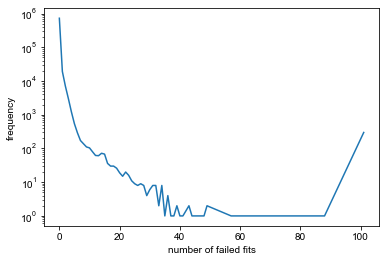

In [29]:
X = my_series.index
Y = my_series.values
plt.figure()
plt.plot(X,Y)
plt.yscale('log')
plt.xlabel('number of failed fits')
plt.ylabel('frequency')
plt.show()

In [30]:
df_total

,openmlid,learner,max_anchor_seen,prediction,beta,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n,curve_model
0,24,SVC_linear,45,"[0.8882253060512815, 0.9129123443101395, 0.932...","[3.4418299555164094, 2.6634082053587433, 0.018...",0,0,2.883226e-08,0.009280,0.030293,2.883226e-08,0.009280,0.030293,45,0.01,4,pow4
1,24,SVC_linear,64,"[0.8880107342619459, 0.9132911872218537, 0.933...","[0.9749338390233945, 19434.87738296287, 3.0299...",0,0,9.987909e-07,0.000413,0.000628,9.987909e-07,0.000413,0.000628,64,0.01,5,pow4
2,24,SVC_linear,91,"[0.8880402887090619, 0.9132249469590998, 0.933...","[0.9748273144231531, 41404.69654147434, 3.1754...",0,0,8.207896e-07,0.000451,0.000634,8.207896e-07,0.000451,0.000634,91,0.01,6,pow4
3,24,SVC_linear,128,"[0.8879204803603522, 0.9137250177077135, 0.932...","[0.9910112534284682, 3.4028442598555797, 1.106...",0,0,1.857116e-06,0.000071,0.000084,1.857116e-06,0.000071,0.000084,128,0.02,7,pow4
4,24,SVC_linear,181,"[0.8878519374777576, 0.9139775632395017, 0.932...","[0.9982729629370699, 1.286412335833199, 0.8414...",0,0,1.766385e-06,0.000015,0.000006,1.766385e-06,0.000015,0.000006,181,0.03,8,pow4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78075,40668,sklearn.tree.ExtraTreeClassifier,8192,"[0.5222589272226801, 0.5291752066764958, 0.535...","[111.87466275358531, 149.9942324352611, -0.036...",0,0,4.650329e-05,0.000149,0.000167,4.650329e-05,0.000149,0.000167,8192,0.14,19,logpower3
78076,40668,sklearn.tree.ExtraTreeClassifier,11585,"[0.521376958849426, 0.5284236038385511, 0.5349...","[127.36760447759718, 150.68239991663455, -0.03...",0,0,4.831424e-05,0.000099,0.000096,4.831424e-05,0.000099,0.000096,11585,0.20,20,logpower3
78077,40668,sklearn.tree.ExtraTreeClassifier,16384,"[0.5205428218287173, 0.5277046723702262, 0.534...","[139.85412544281138, 150.6689381729169, -0.037...",0,0,4.986637e-05,0.000056,0.000051,4.986637e-05,0.000056,0.000051,16384,0.28,21,logpower3
78078,40668,sklearn.tree.ExtraTreeClassifier,23170,"[0.5200052330792921, 0.5272367680674765, 0.533...","[137.23693674088128, 148.624058705217, -0.0382...",0,0,4.926202e-05,0.000041,0.000030,4.926202e-05,0.000041,0.000030,23170,0.40,22,logpower3


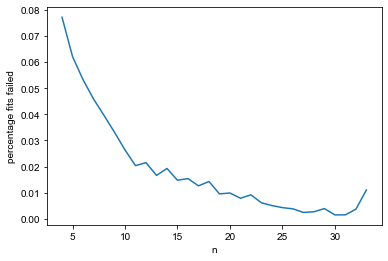

In [31]:
X = []
Y = []
for (n, df_temp) in (df_removed.groupby('n')):
    X.append(n)
    num_total = len(df_total.query('n==%d'%n))
    Y.append(len(df_temp)/num_total)
plt.figure()
plt.plot(X,Y)
plt.xlabel('n')
plt.ylabel('percentage fits failed')
plt.show()



In [32]:
df_removed['reason'].value_counts()

too_bad       24846
nan_or_inf      307
fail            298
Name: reason, dtype: int64

In [33]:
df_removed['curve_model'].unique()

array(['exp2', 'expp3', 'expd3', 'exp3', 'wbl4', 'exp4', 'lin2', 'pow4',
       'vap3', 'pow3', 'mmf4', 'pow2', 'logpower3'], dtype=object)

# Statistics per curve model and curve model table

In [34]:
rows = []
for [curve_model, df_removed_curve] in df_removed.groupby('curve_model'):
    too_bad = (df_removed_curve['reason'] == 'too_bad').sum()
    nan_or_inf = (df_removed_curve['reason'] == 'nan_or_inf').sum()
    fail = (df_removed_curve['reason'] == 'fail').sum()
    total = len(df_removed_curve)
    rows.append([curve_model,fail,nan_or_inf,too_bad,total])
failfits = pd.DataFrame(rows,columns=['curve model','fail','nan or inf','too bad','total'])
row_total = failfits.iloc[:,[1,2,3,4]].sum()
total = list(row_total)
rows.append(['all',total[0],total[1],total[2],total[3]])
failfits = pd.DataFrame(rows,columns=['curve_model','fail','nan_or_inf','too_bad','total'])
failfits

,curve_model,fail,nan_or_inf,too_bad,total
0,exp2,297,278,13699,14274
1,exp3,0,12,453,465
2,exp4,0,2,367,369
3,expd3,0,9,520,529
4,expp3,1,0,242,243
5,lin2,0,0,5880,5880
6,logpower3,0,0,9,9
7,mmf4,0,0,217,217
8,pow2,0,0,50,50
9,pow3,0,0,605,605


In [35]:
from sympy import latex

from sympy.utilities.lambdify import lambdify
import sympy as sym

def get_fun_sym(model_id):
    
    x = sym.Symbol('x')
    y = sym.Symbol('y')
    a = sym.Symbol('a')
    b = sym.Symbol('b')
    c = sym.Symbol('c')
    d = sym.Symbol('d')
    
    if model_id == 'pow2':
        fun = -a * x **(-b)
    if model_id == 'pow3':
        fun = a - b * x **(-c)
    if model_id == 'log2':
        fun = -a * sym.log(x) + b
    if model_id == 'exp3':
        fun = a * sym.exp(-b*x) + c
    if model_id == 'exp2':
        fun = a * sym.exp(-b*x)
    if model_id == 'lin2':
        fun = a * x + b
    if model_id == 'vap3':
        fun = sym.exp(a + b/x + c * sym.log(x))
    if model_id == 'mmf4':
        fun = (a * b + c * x ** d)/(b + x ** d)
    if model_id == 'wbl4':
        fun = (c - b * sym.exp(-a*(x**d)))
    if model_id == 'exp4':
        fun = c - sym.exp(-a*(x**d) + b)
    if model_id == 'expp3':
        fun = c - sym.exp((x-b)**a)
    if model_id == 'pow4':
        fun = a - b*(x + d)**(-c)
    if model_id == 'ilog2':
        fun = b - (a/sym.log(x))
    if model_id == 'expd3':
        fun = c - (c - a)*sym.exp(-b*x)
    if model_id == 'logpower3':
        fun = a / (1 + (x / sym.exp(b))**c)
    if model_id == 'last1':
        fun = a
    return fun

model_names = ['pow4','pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'last1', 'vap3','mmf4','wbl4','exp4','expp3','ilog2','expd3','logpower3']

# order curve models by number of parameters
par = []
for cm in model_names:
    par.append([cm,get_num_par(cm)])
    
df_ordered = pd.DataFrame(par).sort_values(by=1,axis=0)
cm_ordered = df_ordered.iloc[:,0].values
cm_ordered

# references to works that use curve models
ref = dict()
ref['pow2'] = '\\textbf{\\cite{Frey1999}*}\\cite{Gu2001}\\cite{Singh2005}\\cite{Last2007}'
ref['pow3'] = '\\textbf{\\cite{Gu2001}*\\cite{Kolachina2012}*}\\cite{Cortes1994}\\cite{Brumen2012}\\cite{brumen2021overview}'
ref['log2'] = '\\textbf{\\cite{Singh2005}*}\\cite{Frey1999}\\cite{Gu2001}\\cite{Last2007}\\cite{Brumen2012}\\cite{brumen2021overview}'
ref['exp3'] = '\\textbf{\\cite{Brumen2012}*}\\cite{Kolachina2012}\\cite{brumen2021overview}'
ref['exp2'] = '\\cite{Frey1999}\\cite{Singh2005}\\cite{Last2007}'
ref['lin2'] = '\\cite{Frey1999}\\cite{Singh2005}\\cite{Last2007}\\cite{Brumen2012}'
ref['vap3'] = '\\cite{Gu2001}'
ref['mmf4'] = '\\cite{Gu2001}'
ref['wbl4'] = '\\cite{Gu2001}'
ref['exp4'] = '\\cite{Kolachina2012}'
ref['expp3'] = '\\cite{Kolachina2012}'
ref['pow4'] = '\\cite{Kolachina2012}'
ref['ilog2'] = '\\cite{Kolachina2012}'
ref['expd3'] = '\\cite{Kolachina2012}'
ref['logpower3'] = ''
ref['last1'] = ''



In [36]:
from sympy import latex

print('''
\\begin{table}[]
\\ttfamily
\\begin{tabular}{lllllll}
curve model & equation & references & reject & inf or nan & too bad & total\\\\
''',end='')

for cm in cm_ordered:
    fun = get_fun_sym(cm)
    print(cm, end=' & ')
    print('$%s$' % latex(fun), end=' & ')
    print(ref[cm],end=' & ')
    row = failfits.query('curve_model == "%s"' % cm)
    if len(row) == 0:
        print('0 & 0 & 0 & 0 \\\\\n',end='')
    else:
        row=row.iloc[0,:]
        print(row.fail, end=' & ')
        print(row.nan_or_inf, end=' & ')
        print(row.too_bad, end=' & ')
        print(row.total, end='\\\\\n')

print('''\\end{tabular}
\\end{table}
''')
    


\begin{table}[]
\ttfamily
\begin{tabular}{lllllll}
curve model & equation & references & reject & inf or nan & too bad & total\\
last1 & $a$ &  & 0 & 0 & 0 & 0 \\
pow2 & $- a x^{- b}$ & \textbf{\cite{Frey1999}*}\cite{Gu2001}\cite{Singh2005}\cite{Last2007} & 0 & 0 & 50 & 50\\
log2 & $- a \log{\left(x \right)} + b$ & \textbf{\cite{Singh2005}*}\cite{Frey1999}\cite{Gu2001}\cite{Last2007}\cite{Brumen2012}\cite{brumen2021overview} & 0 & 0 & 0 & 0 \\
exp2 & $a e^{- b x}$ & \cite{Frey1999}\cite{Singh2005}\cite{Last2007} & 297 & 278 & 13699 & 14274\\
lin2 & $a x + b$ & \cite{Frey1999}\cite{Singh2005}\cite{Last2007}\cite{Brumen2012} & 0 & 0 & 5880 & 5880\\
ilog2 & $- \frac{a}{\log{\left(x \right)}} + b$ & \cite{Kolachina2012} & 0 & 0 & 0 & 0 \\
pow3 & $a - b x^{- c}$ & \textbf{\cite{Gu2001}*\cite{Kolachina2012}*}\cite{Cortes1994}\cite{Brumen2012}\cite{brumen2021overview} & 0 & 0 & 605 & 605\\
exp3 & $a e^{- b x} + c$ & \textbf{\cite{Brumen2012}*}\cite{Kolachina2012}\cite{brumen2021overview} & 0

# Make percentage buckets

In [37]:
percentage_buckets = [1, 0.8, 0.4, 0.2, 0.1, 0.05]
percentage_buckets = np.array(percentage_buckets)

bucket_list = [np.nan]*(len(df_clean))
bucket_list = np.array(bucket_list)

for i in range(0,len(percentage_buckets)):
    p = percentage_buckets[i]
    inbucket = df_clean['percentage'] < p
    bucket_list = np.where(inbucket.values, p, bucket_list)

df_clean_buckets = df_clean.copy()
df_clean_buckets.insert(0,'percentage_bucket',bucket_list)
df_clean_buckets

,percentage_bucket,openmlid,learner,max_anchor_seen,prediction,beta,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n,curve_model
0,0.05,24,SVC_linear,45,"[0.8882253060512815, 0.9129123443101395, 0.932...","[3.4418299555164094, 2.6634082053587433, 0.018...",0,0,2.883226e-08,0.009280,0.030293,2.883226e-08,0.009280,0.030293,45,0.01,4,pow4
1,0.05,24,SVC_linear,64,"[0.8880107342619459, 0.9132911872218537, 0.933...","[0.9749338390233945, 19434.87738296287, 3.0299...",0,0,9.987909e-07,0.000413,0.000628,9.987909e-07,0.000413,0.000628,64,0.01,5,pow4
2,0.05,24,SVC_linear,91,"[0.8880402887090619, 0.9132249469590998, 0.933...","[0.9748273144231531, 41404.69654147434, 3.1754...",0,0,8.207896e-07,0.000451,0.000634,8.207896e-07,0.000451,0.000634,91,0.01,6,pow4
3,0.05,24,SVC_linear,128,"[0.8879204803603522, 0.9137250177077135, 0.932...","[0.9910112534284682, 3.4028442598555797, 1.106...",0,0,1.857116e-06,0.000071,0.000084,1.857116e-06,0.000071,0.000084,128,0.02,7,pow4
4,0.05,24,SVC_linear,181,"[0.8878519374777576, 0.9139775632395017, 0.932...","[0.9982729629370699, 1.286412335833199, 0.8414...",0,0,1.766385e-06,0.000015,0.000006,1.766385e-06,0.000015,0.000006,181,0.03,8,pow4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78075,0.20,40668,sklearn.tree.ExtraTreeClassifier,8192,"[0.5222589272226801, 0.5291752066764958, 0.535...","[111.87466275358531, 149.9942324352611, -0.036...",0,0,4.650329e-05,0.000149,0.000167,4.650329e-05,0.000149,0.000167,8192,0.14,19,logpower3
78076,0.40,40668,sklearn.tree.ExtraTreeClassifier,11585,"[0.521376958849426, 0.5284236038385511, 0.5349...","[127.36760447759718, 150.68239991663455, -0.03...",0,0,4.831424e-05,0.000099,0.000096,4.831424e-05,0.000099,0.000096,11585,0.20,20,logpower3
78077,0.40,40668,sklearn.tree.ExtraTreeClassifier,16384,"[0.5205428218287173, 0.5277046723702262, 0.534...","[139.85412544281138, 150.6689381729169, -0.037...",0,0,4.986637e-05,0.000056,0.000051,4.986637e-05,0.000056,0.000051,16384,0.28,21,logpower3
78078,0.80,40668,sklearn.tree.ExtraTreeClassifier,23170,"[0.5200052330792921, 0.5272367680674765, 0.533...","[137.23693674088128, 148.624058705217, -0.0382...",0,0,4.926202e-05,0.000041,0.000030,4.926202e-05,0.000041,0.000030,23170,0.40,22,logpower3


# Statistical tests

In [38]:
def convert_table(df,performance_measure,logscale=False):

    curve_models = df['curve_model'].unique()

    rows = []
    info_rows = []
    for (openmlid, df_dataset) in tqdm(df.groupby('openmlid')):
        for (learner, df_learner) in df_dataset.groupby('learner'):
            for (n, df_n) in df_learner.groupby('n'):
                new_row = []
                bucket = df_n.iloc[0,:].percentage_bucket
                info_rows.append([openmlid,learner,n,bucket])
                for curve_model in curve_models:
                    row = df_n.query('curve_model == @curve_model')
                    score = np.nan
                    if len(row) > 0:
                        row = row.iloc[0,:]
                        score = row[performance_measure]
                    new_row.append(score)
                rows.append(new_row)

    a = np.array(rows)
    if logscale == True:
        a = np.log(a)
    a = pd.DataFrame(a,columns=curve_models)
    a_info = np.array(info_rows)
    a_info = pd.DataFrame(a_info,columns=['openmlid','learner','n','bucket'])
    b = pd.concat([a_info,a],axis=1)
    return b

def remove_rows_with_nan_or_inf(c):
    c = c.copy()
    ind_nan_or_inf = c.isin([np.inf, -np.inf, np.nan]).any(axis=1)
    c = c[ind_nan_or_inf == False]
    return c

In [ ]:
if exists('table_MSE_tst_last.p'):
    table_MSE_tst_last = pd.read_pickle('table_MSE_tst_last.p')
else:
    table_MSE_tst_last = convert_table(df_clean_buckets,'MSE_tst_last')
    table_MSE_tst_last.to_pickle('table_MSE_tst_last.p')

if exists('table_MSE_tst.p'):
    table_MSE_tst = pd.read_pickle('table_MSE_tst.p')
else:
    table_MSE_tst = convert_table(df_clean_buckets,'MSE_tst')
    table_MSE_tst.to_pickle('table_MSE_tst.p')

if exists('table_MSE_trn.p'):
    table_MSE_trn = pd.read_pickle('table_MSE_trn.p')
else:
    table_MSE_trn = convert_table(df_clean_buckets,'MSE_trn')
    table_MSE_trn.to_pickle('table_MSE_trn.p')


  0%|          | 0/200 [00:00<?, ?it/s]

In [122]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

def prepare_data_for_cd(b):
    
    c = remove_rows_with_nan_or_inf(b)

    melted = pd.melt(c,id_vars=['openmlid','learner','n'],value_vars=curve_models)
    dataset_name = melted.agg('{0[openmlid]},{0[learner]},{0[n]}'.format, axis=1)
    melted['dataset_name'] = dataset_name

    df_cd = melted[['variable','dataset_name','value']]
    df_cd = df_cd.rename(columns={'variable': 'classifier_name', 'value': 'accuracy'})
    df_cd['accuracy'] = -df_cd['accuracy']
    return df_cd

def cd_plot(df_cd,lowv=1,highv=16,dontplot=[],title=None,auto=True):
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_cd, alpha=0.05)
    
    if auto:
        lowv, highv, dontplot = determine_plotting(p_values,average_ranks)
    
    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=8, textspace=0, labels=True, dpi=600,lowv=lowv,highv=highv,dontplot=dontplot)
    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    return lowv, highv, dontplot

C:\Users\tjviering\AppData\Local\Temp\ipykernel_31344\2561471876.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [123]:
table_MSE_tst_last_all = prepare_data_for_cd(table_MSE_tst_last)
table_MSE_tst_all = prepare_data_for_cd(table_MSE_tst)
table_MSE_trn_all = prepare_data_for_cd(table_MSE_trn)


In [125]:
table_MSE_tst_last_005 = prepare_data_for_cd(table_MSE_tst_last.query('bucket=="0.05"'))
table_MSE_tst_last_010 = prepare_data_for_cd(table_MSE_tst_last.query('bucket=="0.1"'))
table_MSE_tst_last_020 = prepare_data_for_cd(table_MSE_tst_last.query('bucket=="0.2"'))
table_MSE_tst_last_040 = prepare_data_for_cd(table_MSE_tst_last.query('bucket=="0.4"'))
table_MSE_tst_last_080 = prepare_data_for_cd(table_MSE_tst_last.query('bucket=="0.8"'))

table_MSE_tst_005 = prepare_data_for_cd(table_MSE_tst.query('bucket=="0.05"'))
table_MSE_tst_010 = prepare_data_for_cd(table_MSE_tst.query('bucket=="0.1"'))
table_MSE_tst_020 = prepare_data_for_cd(table_MSE_tst.query('bucket=="0.2"'))
table_MSE_tst_040 = prepare_data_for_cd(table_MSE_tst.query('bucket=="0.4"'))
table_MSE_tst_080 = prepare_data_for_cd(table_MSE_tst.query('bucket=="0.8"'))

table_MSE_trn_005 = prepare_data_for_cd(table_MSE_trn.query('bucket=="0.05"'))
table_MSE_trn_010 = prepare_data_for_cd(table_MSE_trn.query('bucket=="0.1"'))
table_MSE_trn_020 = prepare_data_for_cd(table_MSE_trn.query('bucket=="0.2"'))
table_MSE_trn_040 = prepare_data_for_cd(table_MSE_trn.query('bucket=="0.4"'))
table_MSE_trn_080 = prepare_data_for_cd(table_MSE_trn.query('bucket=="0.8"'))

# MSE test last

['0.05' '0.1' '0.2' '0.4' '0.8' '1.0' 'nan']


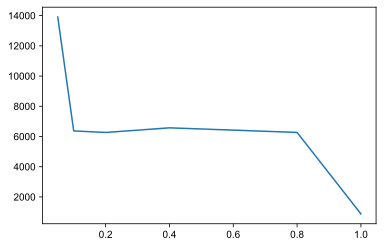

In [150]:
buckets = table_MSE_tst_last['bucket'].unique()
print(buckets)

n_per_bucket = []
bucket_f = []
for b in buckets:
    bucket_f.append(float(b))
    n_per_bucket.append(len(table_MSE_tst_last.query('bucket==@b')))

plt.figure()
plt.plot(bucket_f,n_per_bucket)
plt.show()
    

In [218]:
plots = []
ext = '.png'
plots.append((table_MSE_tst_last_all,'ranking MSE test last','MSE_tst_last'+ext))
plots.append((table_MSE_tst_last_005,'ranking MSE test last <5%','MSE_tst_last_005'+ext))
plots.append((table_MSE_tst_last_010,'ranking MSE test last 5%-10%','MSE_tst_last_010'+ext))
plots.append((table_MSE_tst_last_020,'ranking MSE test last 10%-20%','MSE_tst_last_020'+ext))
plots.append((table_MSE_tst_last_040,'ranking MSE test last 20%-40%','MSE_tst_last_040'+ext))
plots.append((table_MSE_tst_last_080,'ranking MSE test last 40%-80%','MSE_tst_last_080'+ext))

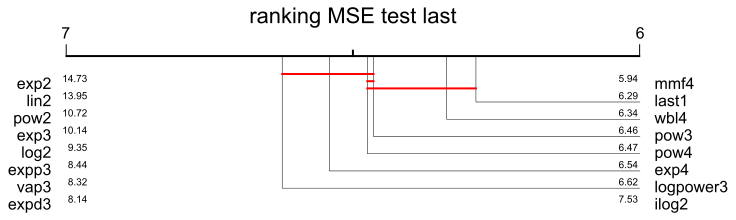

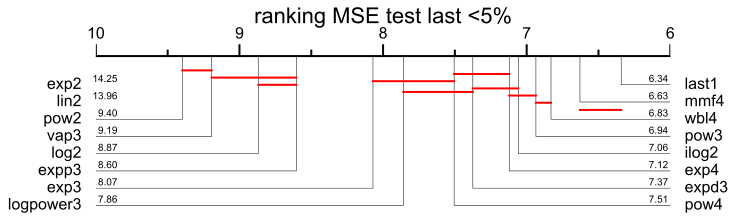

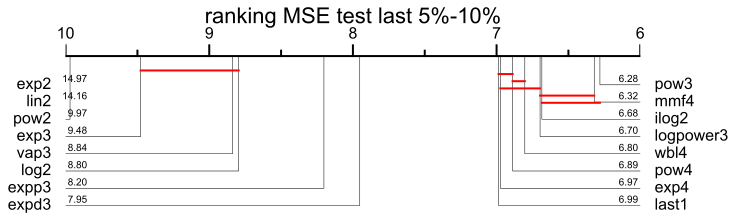

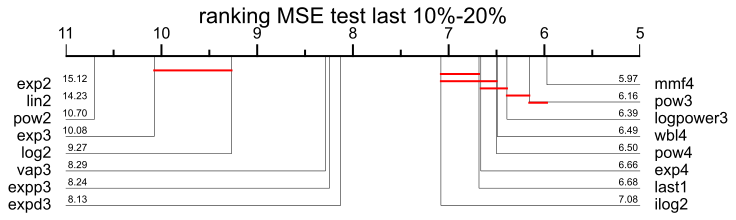

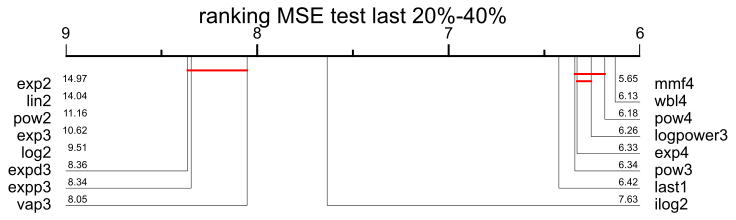

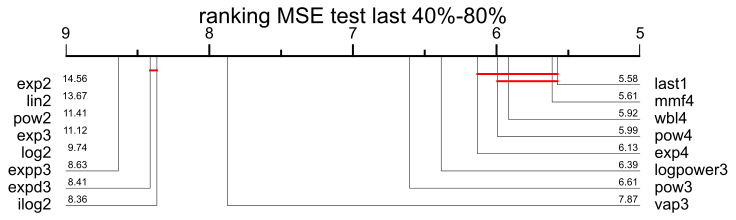

In [220]:
for p in plots:
    table = p[0]
    title = p[1]
    fn = p[2]

    cd_plot(table,title=title)
    plt.savefig(fn,bbox_inches='tight')

# MSE test

['0.05' '0.1' '0.2' '0.4' '0.8' '1.0' 'nan']
[13908, 6370, 6269, 6574, 6271, 879, 9]


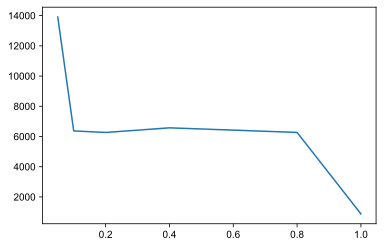

In [159]:
buckets = table_MSE_tst['bucket'].unique()
print(buckets)

n_per_bucket = []
bucket_f = []
for b in buckets:
    bucket_f.append(float(b))
    n_per_bucket.append(len(table_MSE_tst.query('bucket==@b')))
    
print(n_per_bucket)

plt.figure()
plt.plot(bucket_f,n_per_bucket)
plt.show()
    

In [221]:
plots = []
ext = '.png'
plots.append((table_MSE_tst_all,'ranking MSE test ','MSE_tst'+ext))
plots.append((table_MSE_tst_005,'ranking MSE test <5%','MSE_tst_005'+ext))
plots.append((table_MSE_tst_010,'ranking MSE test 5%-10%','MSE_tst_010'+ext))
plots.append((table_MSE_tst_020,'ranking MSE test 10%-20%','MSE_tst_020'+ext))
plots.append((table_MSE_tst_040,'ranking MSE test 20%-40%','MSE_tst_040'+ext))
plots.append((table_MSE_tst_080,'ranking MSE test 40%-80%','MSE_tst_080'+ext))

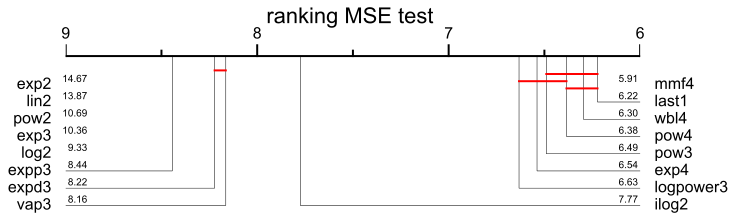

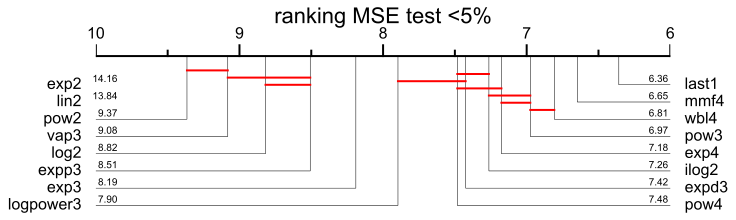

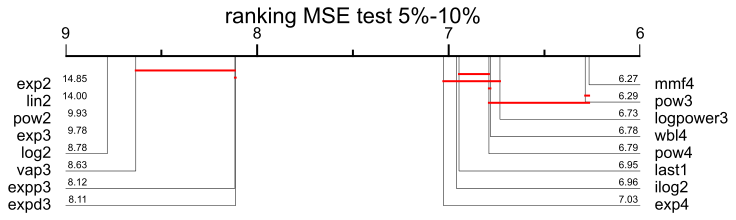

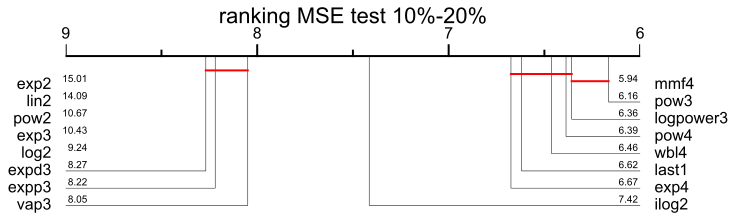

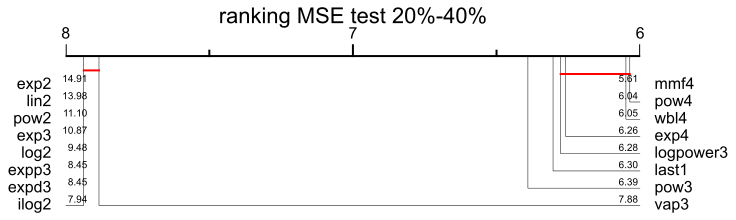

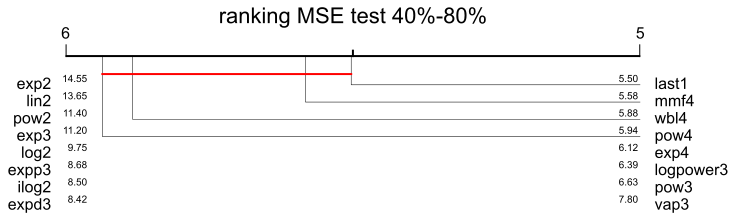

In [222]:
for p in plots:
    table = p[0]
    title = p[1]
    fn = p[2]

    cd_plot(table,title=title)
    plt.savefig(fn,bbox_inches='tight')

# MSE trn

['0.05' '0.1' '0.2' '0.4' '0.8' '1.0' 'nan']
[13908, 6370, 6269, 6574, 6271, 879, 9]


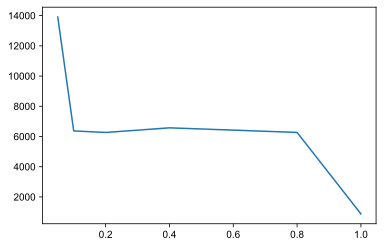

In [160]:
buckets = table_MSE_trn['bucket'].unique()
print(buckets)

n_per_bucket = []
bucket_f = []
for b in buckets:
    bucket_f.append(float(b))
    n_per_bucket.append(len(table_MSE_trn.query('bucket==@b')))
    
print(n_per_bucket)

plt.figure()
plt.plot(bucket_f,n_per_bucket)
plt.show()
    

In [223]:
plots = []
ext = '.png'
plots.append((table_MSE_trn_all,'ranking MSE train ','MSE_trn'+ext))
plots.append((table_MSE_trn_005,'ranking MSE train <5%','MSE_trn_005'+ext))
plots.append((table_MSE_trn_010,'ranking MSE train 5%-10%','MSE_trn_010'+ext))
plots.append((table_MSE_trn_020,'ranking MSE train 10%-20%','MSE_trn_020'+ext))
plots.append((table_MSE_trn_040,'ranking MSE train 20%-40%','MSE_trn_040'+ext))
plots.append((table_MSE_trn_080,'ranking MSE train 40%-80%','MSE_trn_080'+ext))

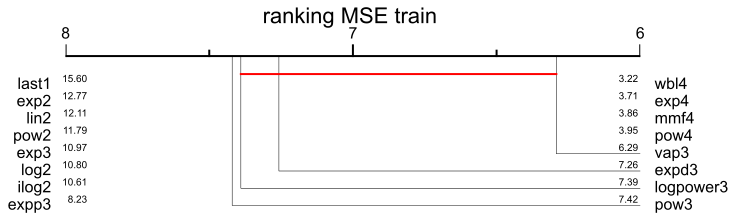

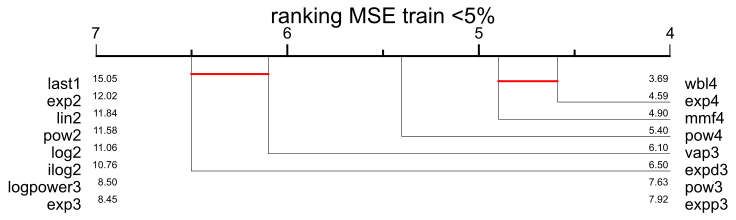

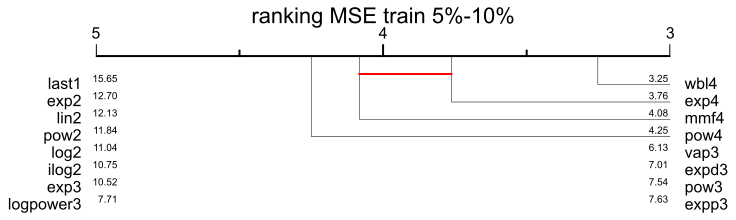

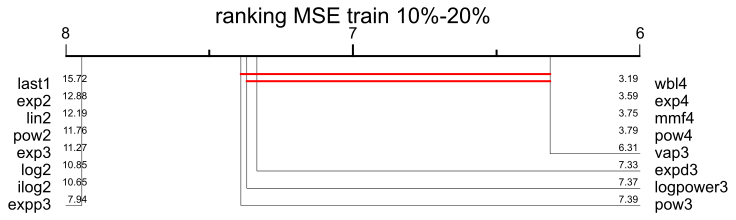

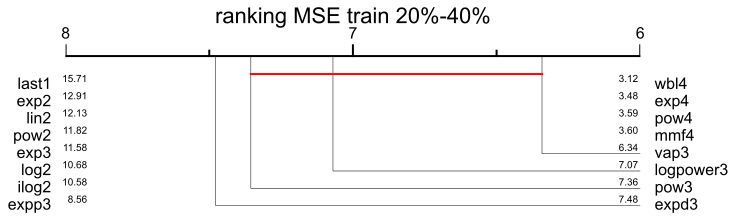

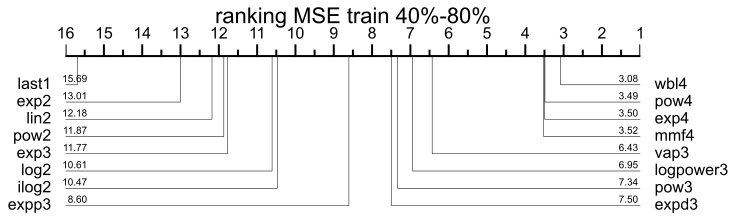

In [224]:
for p in plots:
    table = p[0]
    title = p[1]
    fn = p[2]

    cd_plot(table,title=title)
    plt.savefig(fn,bbox_inches='tight')

# Visualize a learning curve

In [165]:
def get_XY(row):
    learner = row.learner
    openmlid = row.openmlid
    [X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)
    return [X, Y]


In [339]:
def set_ylim(row, margin=0.05):
    
    [X, Y] = get_XY(row)
    Y_diff = np.max(Y) - np.min(Y)
    plt.ylim([np.min(Y),np.max(Y)])
    #plt.ylim([np.min(Y) - Y_diff*margin,np.max(Y) + Y_diff*margin])


def plot_data(row):
    
    [X, Y] = get_XY(row)

    plt.plot(X,Y,'*r',label='test data')
    set_ylim(row)
    plt.xlabel('anchors')
    plt.ylabel('accuracy')
    
    learner = row.learner
    openmlid = row.openmlid
    plt.title('%s dataset %d' % (learner, openmlid))

def plot_trn_data(row):
    
    [X, Y] = get_XY(row)
    
    offset = np.argwhere(X == row.max_anchor_seen)[0][0]

    X_trn = X[:offset+1]
    Y_trn = Y[:offset+1]
    
    plt.plot(X_trn,Y_trn,'ob',label='train data')
    set_ylim(row)
    plt.xlabel('anchors')
    plt.ylabel('accuracy')
    
    learner = row.learner
    openmlid = row.openmlid
    plt.title('%s dataset %d' % (learner, openmlid))

def get_curve_models(df,row):
    
    learner = row.learner
    openmlid = row.openmlid
    max_anchor_seen = row.max_anchor_seen
    
    df_models = df_clean.query('learner == "%s" and openmlid == @openmlid and max_anchor_seen == @max_anchor_seen' % learner)
    
    return df_models

def get_curve_model(df,row,cm):
    
    df_models = get_curve_models(df,row)
    df_models2 = df_models.query('curve_model == "%s"' % cm)
    my_row = df_models2.iloc[0,:]
    return my_row
    
def plot_prediction(row):
    
    curve_model = row.curve_model
    [X, Y] = get_XY(row)
    
    plt.plot(X,row.prediction,':',label=curve_model)
    plt.legend()
    
def plot_prediction_smooth(row):
    
    curve_model = row.curve_model
    
    [X, Y] = get_XY(row)
    
    fun = get_fun_model_id(row.beta,curve_model)
    
    X_plot = np.arange(np.min(X),np.max(X))
    Y_hat = fun(X_plot)
    
    plt.plot(X_plot,Y_hat,'-',label=curve_model)
    plt.legend()



441371


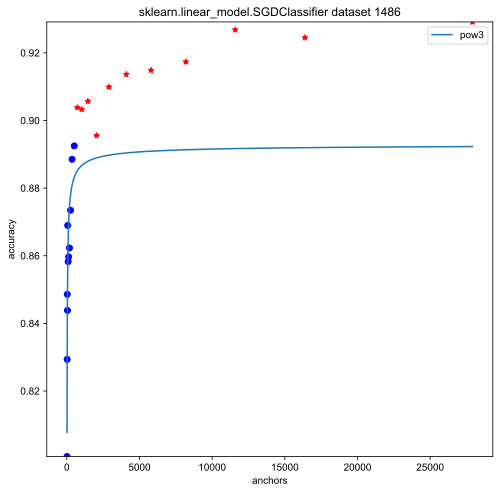

In [325]:
num = np.random.randint(0,len(df_clean))
#row = df_clean.sample()
#row = df_removed.sample()
#row = df_no_fail_no_nan_or_inf_no_too_bad.sample()
row = df_clean.iloc[num,:]

get_curve_model(df,row,cm):


print(num)

plt.figure(figsize=(8,8))
plot_data(row)
plot_trn_data(row)
#plot_prediction(row)
plot_prediction_smooth(row)
plt.show()

In [352]:
mmf4_curves = df_clean.query('curve_model == "mmf4"')




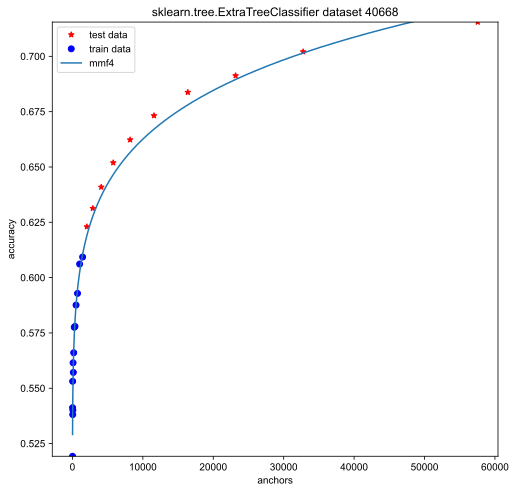

In [362]:
best = mmf4_curves.sort_values(by='MSE_tst',axis=0)

row = mmf4_curves.iloc[-10,:]

plt.figure(figsize=(8,8))
plot_data(row)
plot_trn_data(row)
#plot_prediction(row)
plot_prediction_smooth(row)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


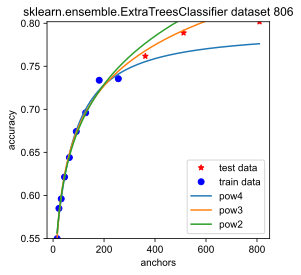

In [351]:
#num = 441371
num = np.random.randint(0,len(df_clean))

#row = df_clean.sample()
#row = df_removed.sample()
#row = df_no_fail_no_nan_or_inf_no_too_bad.sample()
row = df_clean.iloc[num,:]

plt.figure(figsize=(4,4))
plot_data(row)
plot_trn_data(row)
#plot_prediction_smooth(row)

rows = get_curve_models(df_clean,row)

rows = rows.iloc[[0,1,2],:]

for index, myrow in rows.iterrows():
    plot_prediction_smooth(myrow)

plt.savefig('power_laws.eps')
plt.savefig('power_laws.png')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


15193


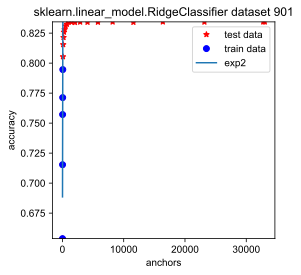

In [347]:
num = 15193
row = df_removed.iloc[num,:]

print(num)

plt.figure(figsize=(4,4))
plot_data(row)
plot_trn_data(row)
plot_prediction_smooth(row)
plt.savefig('bad_fit.eps')
plt.savefig('bad_fit.png')

In [338]:
row.MSE_tst_last

3.387797405762078e+97

192358


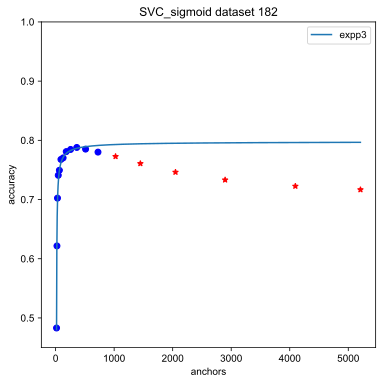

In [178]:
num = 192358
row = df_clean.iloc[num,:]

print(num)

plt.figure(figsize=(6,6))
plot_data(row)
plot_trn_data(row)
#plot_prediction(row)
plot_prediction_smooth(row)
plt.ylim([0.45,1])


In [209]:
row

openmlid                                                         182
learner                                                  SVC_sigmoid
max_anchor_seen                                                  724
prediction         [0.4821, 0.6271, 0.6961, 0.7351, 0.7572, 0.769...
beta               [0.7844010810311779, 22.784756333508724, 1.629...
fails_init                                                         0
fails_fit                                                          0
MSE_trn                                                     0.000021
MSE_tst                                                     0.002189
MSE_tst_last                                                0.004585
L1_trn                                                      0.000021
L1_tst                                                      0.002189
L1_tst_last                                                 0.004585
max anchor seen                                                  724
percentage                        

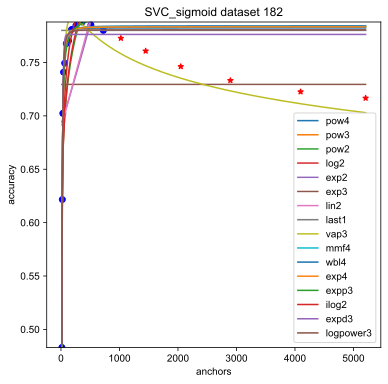

In [215]:
num = 192358
row = df_clean.iloc[num,:]

rows = get_curve_models(df_clean,row)

plt.figure(figsize=(6,6))
plot_data(row)
plot_trn_data(row)
#plot_prediction(row)
for index, myrow in rows.iterrows():
    plot_prediction_smooth(myrow)
plt.show()

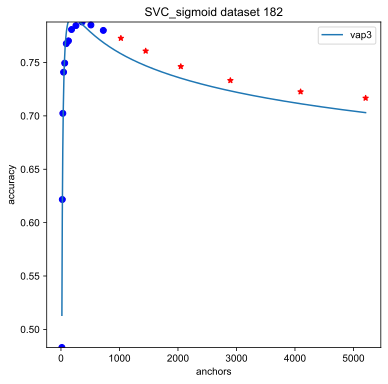

In [216]:
num = 192358
row = df_clean.iloc[num,:]

rowvap3 = get_curve_model(df_clean,row,'vap3')

plt.figure(figsize=(6,6))
plot_data(row)
plot_trn_data(row)
plot_prediction_smooth(rowvap3)

plt.show()

In [184]:
row

openmlid                                                         182
learner                                                  SVC_sigmoid
max_anchor_seen                                                  724
prediction         [0.4802, 0.6399, 0.6963, 0.7282, 0.7485, 0.762...
beta               [-0.7613967945376751, 10.576910785709916, 1.79...
fails_init                                                         1
fails_fit                                                          1
MSE_trn                                                     0.000061
MSE_tst                                                     0.003271
MSE_tst_last                                                0.006387
L1_trn                                                      0.000061
L1_tst                                                      0.003271
L1_tst_last                                                 0.006387
max anchor seen                                                  724
percentage                        

In [187]:
max_anchor_seen


724

In [206]:

learner = row.learner
openmlid = row.openmlid
max_anchor_seen = row.max_anchor_seen

df_models = df_clean.query('learner == "%s" and openmlid == @openmlid and max_anchor_seen == @max_anchor_seen' % learner)
df_models

,openmlid,learner,max_anchor_seen,prediction,beta,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n,curve_model
7336,182,SVC_sigmoid,724,"[0.4821, 0.6271, 0.6961, 0.7351, 0.7572, 0.769...","[0.7844010810311779, 22.784756333508724, 1.629...",0,0,0.000021,0.002189,0.004585,0.000021,0.002189,0.004585,724,0.14,12,pow4
7350,182,SVC_sigmoid,724,"[0.4826, 0.6259, 0.696, 0.7359, 0.7581, 0.77, ...","[0.7835889938171334, 41.99975262269896, 1.7811...",0,0,0.000021,0.002125,0.004478,0.000021,0.002125,0.004478,724,0.14,12,pow3
7364,182,SVC_sigmoid,724,"[0.6312, 0.6484, 0.6644, 0.6814, 0.6994, 0.717...","[-0.5142476121454583, -0.0739337655969914]",0,0,0.003230,0.033258,0.063260,0.003230,0.033258,0.063260,724,0.14,12,pow2
7378,182,SVC_sigmoid,724,"[0.6206, 0.6414, 0.6602, 0.6797, 0.6998, 0.719...","[-0.05708392934154106, 0.46236426695175714]",0,0,0.002973,0.029779,0.054857,0.002973,0.029779,0.054857,724,0.14,12,log2
7392,182,SVC_sigmoid,724,"[0.6943, 0.6956, 0.6972, 0.6995, 0.703, 0.7078...","[0.6915030209065215, -0.0002565844593047436]",0,0,0.005804,1.002305,3.664989,0.005804,1.002305,3.664989,724,0.14,12,exp2
7406,182,SVC_sigmoid,724,"[0.7295, 0.7295, 0.7295, 0.7295, 0.7295, 0.729...","[105.30996251605487, 32.54180025679394, 0.7295...",0,0,0.007626,0.000560,0.000164,0.007626,0.000560,0.000164,724,0.14,12,exp3
7420,182,SVC_sigmoid,724,"[0.6915, 0.6929, 0.6948, 0.6974, 0.7013, 0.706...","[0.00020349866420397538, 0.6882440209439616]",0,0,0.005712,0.365365,1.063819,0.005712,0.365365,1.063819,724,0.14,12,lin2
7434,182,SVC_sigmoid,724,"[0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.780...",[0.7800919999999999],0,0,0.010185,0.001849,0.004022,0.010185,0.001849,0.004022,724,0.14,12,last1
7448,182,SVC_sigmoid,724,"[0.5132, 0.6071, 0.6729, 0.7225, 0.757, 0.778,...","[0.08764671711940476, -9.8038862080065, -0.051...",0,0,0.000266,0.000155,0.000185,0.000266,0.000155,0.000185,724,0.14,12,vap3
7462,182,SVC_sigmoid,724,"[0.4826, 0.6259, 0.696, 0.7359, 0.7581, 0.77, ...","[0.7835889877535785, 13113.802375443018, -5507...",0,2,0.000021,0.002125,0.004478,0.000021,0.002125,0.004478,724,0.14,12,mmf4


In [ ]:
plt.boxplot(df_clean['MSE_trn'])
plt.ylabel('log')

In [ ]:
df_removed['n'].value_counts()

# Distribution of MSEs

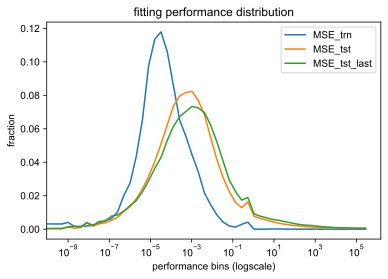

In [217]:
def plot_metric(series,my_metric,ls='-'):
    curbin = 0.0000000005
    binlist = [0]
    while curbin < 1000000:
        binlist.append(curbin)
        curbin *= 2
    [hist,edges] = np.histogram(series,bins=binlist)
    plt.plot(edges[:-1],hist/np.sum(hist),ls,label=my_metric)
    plt.xscale('log')

plt.figure()    

plot_metric(df_total['MSE_trn'],'MSE_trn')
plot_metric(df_total['MSE_tst'],'MSE_tst')
plot_metric(df_total['MSE_tst_last'],'MSE_tst_last')

plt.xlabel('performance bins (logscale)')
plt.ylabel('fraction')
plt.legend()
plt.title('fitting performance distribution')
plt.show()

In [316]:
def empirical_cdf(series,my_metric,ls='-',label=''):
    a = series.values
    plt.plot(np.sort(a), np.linspace(0, 1, len(a), endpoint=False), ls,label=label)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


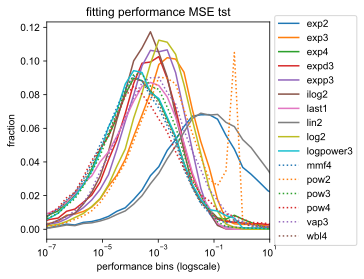

In [367]:
plt.figure(figsize=(5,4),dpi=100)
ax = plt.subplot(111)

i = 0
for [curve_model, df_curve_model] in df_total.groupby('curve_model'):
    ls = '-'
    if i > 9:
        ls = ':'
    plot_metric(df_curve_model['MSE_tst'],curve_model,ls=ls)
    #empirical_cdf(df_curve_model['MSE_tst'],curve_model,ls=ls,label=curve_model)
    i += 1

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
plt.xlabel('performance bins (logscale)')
plt.ylabel('fraction')
plt.legend()
plt.title('fitting performance MSE tst')

plt.xscale('log')
plt.xlim([1e-7,1e1])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('distribution_per_learner.png')
plt.savefig('distribution_per_learner.eps')
plt.show()

C:\Users\tjviering\Anaconda3\envs\lcfit2\lib\site-packages\numpy\ma\core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


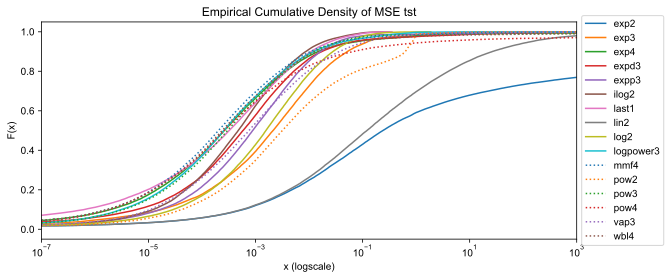

In [321]:
plt.figure(figsize=(12,4),dpi=100)
ax = plt.subplot(111)

i = 0
for [curve_model, df_curve_model] in df_total.groupby('curve_model'):
    ls = '-'
    if i > 9:
        ls = ':'
    #plot_metric(df_curve_model['MSE_tst'],curve_model,ls=ls)
    empirical_cdf(df_curve_model['MSE_tst'],curve_model,ls=ls,label=curve_model)
    i += 1

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
plt.xlabel('x (logscale)')
plt.ylabel('F(x)')
plt.legend()
plt.title('Empirical Cumulative Density of MSE tst')

plt.xscale('log')
plt.xlim([1e-7,1e3])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
plt.figure(figsize=(16,4),dpi=100)
ax = plt.subplot(111)

i = 0
for [n, df_n] in df_total.groupby('fraction'):
    ls = '-'
    plot_metric(df_n['MSE_tst'],str(n),ls=ls)
    i += 1

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
plt.xlabel('performance bins (logscale)')
plt.ylabel('fraction')
plt.legend()
plt.title('fitting performance MSE tst')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [368]:
df_clean['n'].unique()

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], dtype=int64)

# Learning curve of a learning curve

In [ ]:
import seaborn as sns
plt.figure()
sns.boxplot(y="MSE_tst_last", data=df_total_clean, palette="Set3") 
plt.ylim([0,0.5])
plt.show()

In [ ]:
percentage = 0.25
percentage_buckets = [0.05, 0.1, 0.2, 0.4, 1]
percentage_buckets = np.array(percentage_buckets)
bucket = np.argwhere(percentage < percentage_buckets)[0][0]
bucket

In [ ]:
#df_total_clean = df_total_clean.query('openmlid == 11')

percentage_buckets = [0.05, 0.1, 0.2, 0.4, 1]
percentage_buckets = np.array(percentage_buckets)

buckets = []

for i in range(0,len(df_total_clean)):
    row = df_total_clean.iloc[i,:]
    percentage = row.percentage
    bucket = np.argwhere(percentage < percentage_buckets)[0][0]
    buckets.append(bucket)

df_total_clean.insert(0,'quartile',buckets)


In [ ]:
df_total_clean['quartile'].hist()

In [ ]:
type(row)

In [ ]:
selected = df_total_clean
#selected = df_total_clean.query('openmlid == 11')

num_datasets = len(selected['openmlid'].unique())

fig, axs = plt.subplots(num_datasets,figsize = (8,8*num_datasets))

j = 0
for openmlid, df_dataset in selected.groupby("openmlid"):
    i = 0
    ls = '-'
    for curve_model, df_curve_model in df_dataset.groupby("curve_model"):

        Y = df_curve_model.groupby('percentage')['MSE_tst_last'].median()
        Y_sigma = df_curve_model.groupby('percentage')['MSE_tst_last'].std()
        X = df_curve_model.groupby('percentage')['MSE_tst_last'].median().index
        if i > 9:
            ls = ':'
        if num_datasets > 1:
            my_ax = axs[j]
        else:
            my_ax = axs
        my_ax.plot(X,Y,ls,label=curve_model)
        
        i += 1
    my_ax.set_ylim([0,0.002])
    my_ax.set_title('openmlid %d' % openmlid)
    j += 1
    
plt.xlabel('percentage of anchors used')
plt.ylabel('median MSE on last anchor')
plt.legend()
plt.show()


In [ ]:
selected = df_total_clean

plt.figure(figsize=(8,8))

ls = '-'
i = 0
for curve_model, df_curve_model in selected.groupby("curve_model"):

    Y = df_curve_model.groupby('quartile')['MSE_tst_last'].median()
    Y_sigma = df_curve_model.groupby('quartile')['MSE_tst_last'].std()
    X = df_curve_model.groupby('quartile')['MSE_tst_last'].median().index

    if i > 9:
        ls = ':'
    i += 1
    plt.plot(X,Y,ls,label=curve_model)
    
plt.xlabel('# anchors used')
plt.ylabel('median MSE')
plt.legend()
plt.ylim([0,0.003])
plt.show()


In [ ]:
import seaborn as sns
plt.figure(figsize=(6,6))
sns.boxplot(x="quartile", y="MSE_tst_last", data=df_total_clean, palette="Set3") 
plt.ylim([0,0.4])
plt.show()

In [ ]:
percentage_buckets_str = ['curve_model']
for perc in percentage_buckets:
    percentage_buckets_str.append(str(perc))
percentage_buckets_str = percentage_buckets_str

In [ ]:
row

In [ ]:
rows

In [ ]:
percentage_buckets_str

In [ ]:
rows = []
for curve_model, df_subgroup in df_total_clean.groupby(["curve_model"]):
    row = [curve_model]
    for quartile, df_subgroup2 in df_subgroup.groupby(['quartile']):
        row.append(df_subgroup2['MSE_tst_last'].median())
    rows.append(row)
    
my_res = pd.DataFrame(rows,columns=[percentage_buckets_str])



In [ ]:
my_res

In [ ]:
my_res_ranks = my_res.copy()
for col in percentage_buckets_str:
    if col == 'curve_model':
        continue
    my_res_ranks[col] = my_res_ranks[col].rank(method='average')
my_res_ranks['0.05']

In [ ]:
print('\\begin{table}[]')
print('\\ttfamily')
print('\\begin{tabular}{lllll}')
for (i,text) in enumerate(percentage_buckets_str):
    if text == 'curve_model':
        text = 'curve model'
    if i == 0:
        print('%12s' % text,' ',end='')
    else:
        print('%8s' % text,' ',end='')
    if i < 4:
        print('&',end='')
print('\\\\')
first = True
for i in range(0,len(my_res)):
    row = my_res.iloc[i,:]
    for (j,num) in enumerate(row.values):
        if j == 0:
            if num == 'baseline_last_constant':
                num = 'last1'
            print('%12s' % num,' ',end='')
        else:
            rank = my_res_ranks.iloc[i,j]
            if rank >= 1 and rank <= 3.5: # [1,2,3]:
                print('\\cellcolor{YellowGreen}{%8.5f} '%num,end='')
            elif rank > 3.5 and rank <= 7.5: # in [4, 5, 6, 7]:
                print('\\cellcolor{Goldenrod}{%8.5f} '%num,end='')
            elif rank > 7.5 and rank <= 10.5: #rank in [8, 9, 10]:
                print('\\cellcolor{White}{%8.5f} '%num,end='')
            elif rank > 10.5 and rank <= 14: # rank in [12,13,14]:
                print('\\cellcolor{Gray}{%8.5f} '%num,end='')
            else:
                print('\\cellcolor{Red}{%8.5f} '%num,end='')
                #print(' ')
                #print(rank)
                #print(' ')
        if j < 4:
            print('&',end='')
    print('\\\\')
print('\\end{tabular}')
print('\\end{table}')

In [ ]:
a = df_total_clean.groupby('curve_model')['MSE_tst_last'].median()
a.sort_values()

In [ ]:
df_total_clean['learner']

In [ ]:
df_total_clean.groupby('learner')['MSE_tst_last'].median().sort_values()

In [ ]:
df_total_clean.describe()

# Look at parameter values

In [ ]:
beta

In [ ]:

beta_str = beta[0]
beta_str = beta_str[1:-1]
beta_parts = beta_str.split(' ')
myfloat = []
for part in beta_parts:
    part = part.replace(',','')
    part = part.replace('\n','')
    myfloat.append(float(part))
myfloat = tuple(myfloat)
return myfloat

In [ ]:
num_curve_models = df_total_clean['curve_model'].unique()
num_curve_models

In [ ]:
row.beta

In [ ]:
beta_list

In [ ]:
df_selected

In [ ]:
plt.figure()
j = 0
df_selected = df_total_clean.query('curve_model == "lin2"')
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = parse_beta([row.beta])
        beta2 = list(beta)
        beta_list.append(beta2)

#    a = np.array(beta_list)
#    plt.boxplot(a)
#    plt.ylim([-0.25,0.25])


In [ ]:
for [i, beta] in enumerate(beta_list):
    if not len(beta) == 2:
        print(i,beta)

In [ ]:
beta_list = []
i = 0
row = df_dataset.iloc[i,:]
beta = parse_beta([row.beta])
beta2 = list(beta)
beta_list.append(beta2)
i = 1
row = df_dataset.iloc[i,:]
beta = parse_beta([row.beta])
beta2 = list(beta)
beta_list.append(beta2)
i = 2
row = df_dataset.iloc[i,:]
beta = parse_beta([row.beta])
beta2 = list(beta)
beta_list.append(beta2)
beta_list

In [ ]:
df_total_clean

#df_selected = df_total_clean.query('curve_model == "lin2" and MSE_trn < 0.05')
#df_selected = df_total_clean.query('curve_model == "lin2"')
df_selected = df_total_clean

fig, axs = plt.subplots(len(num_curve_models),figsize=(15,15))
j = 0
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = parse_beta([row.beta])
        beta_list.append(beta)

    a = np.array(beta_list)
    axs[j].boxplot(a)
    axs[j].set_ylim([-2,2])
    axs[j].set_title(curve_model)
    j = j+1

In [ ]:
np.array(beta_list).shape

In [ ]:
total_list = np.empty((1,1))
total_list.shape

In [ ]:
df_total_clean

#df_selected = df_total_clean.query('curve_model == "lin2" and MSE_trn < 0.05')
#df_selected = df_total_clean.query('curve_model == "lin2"')
df_selected = df_total_clean

first = True
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = row.beta
        beta_list.append(beta)
    beta_list = np.array(beta_list)
    if first:
        total_list = np.reshape(beta_list,(-1,1))
        first = False
    else:
        total_list = np.hstack((total_list,beta_list))
    

In [ ]:
pd.DataFrame(total_list).describe()

In [ ]:
total_list.shape

# Visualize fits

In [ ]:
df_total_clean

In [ ]:
df

In [ ]:
learners = df['learner'].unique()
learners

In [ ]:

learner = learners[18]
openmlid = 11
n = 9
df_selected = df_total_clean.query('openmlid==@openmlid and learner==@learner and n==@n')
df_selected

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

plt.figure(figsize=(8,8))
plt.plot(X,Y,'*')
for i in range(0,len(df_selected)):
    row = df_selected.iloc[i,:]
    Y_hat = row.prediction
    plt.plot(X,Y_hat,'-',label=row.curve_model)
    
plt.title('%s dataset %d' % (learner, openmlid))
plt.ylim([np.min(Y),np.max(Y)])
plt.xlabel('train samples')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [ ]:
learner = 'sklearn.linear_model.Perceptron'

In [ ]:
#    def exp3(beta):
#        a, b, c = tuple(beta.astype(float))
#        pl = lambda x: a * np.exp(-b*x) + c

In [ ]:
def get_pow4(sizes, scores):
    def pow4(beta):
        a, b, c, d = tuple(beta.astype(float))
        pl = lambda x: c - (-a*x + b)**d
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(pow4, np.array([0.0001,0.2,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: c - (-a*x + b)**d

In [ ]:
[beta,func] = get_exp2_good_init(X,Y)

In [ ]:
Y_hat

In [ ]:
learner = learners[0]
openmlid = 11

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

beta, pow4 = get_pow4(X,Y)

Y_hat = pow4(X)

plt.figure()
plt.plot(X,Y,'*')
plt.plot(X, Y_hat, '-o')


In [ ]:
beta

In [ ]:
beta

# Learner influence

In [ ]:
df_total_clean.boxplot(column='MSE_tst_last',by='learner',rot=90)
plt.ylim([0,0.1])

# Curve model influence

In [ ]:
df_total_clean.boxplot(column='MSE_tst_last',by='curve_model',rot=90)
plt.ylim([0,0.1])

# Compute Jacobians

In [289]:
from sympy.utilities.lambdify import lambdify
import sympy as sym

def get_fun_sym(model_id):
    
    x = sym.Symbol('x')
    y = sym.Symbol('y')
    a = sym.Symbol('a')
    b = sym.Symbol('b')
    c = sym.Symbol('c')
    d = sym.Symbol('d')
    
    if model_id == 'pow2':
        fun = sym.Matrix([-a * x **(-b)])
        fun = -a * x **(-b)
        #J = np.array([-X**(-b), a*X**(-b)*np.log(X)])
    if model_id == 'pow3':
        fun = sym.Matrix([a - b * x **(-c)])
        fun = a - b * x **(-c)
        #J = np.array([np.ones_like(X), -X**(-c), b*X**(-c)*np.log(X)])
    if model_id == 'log2':
        fun = sym.Matrix([-a * sym.log(x) + b])
        fun = -a * sym.log(x) + b
        #J = np.array([-np.log(X), np.ones_like(X)])
    if model_id == 'exp3':
        fun = sym.Matrix([a * sym.exp(-b*x) + c])
        fun = a * sym.exp(-b*x) + c
        #J = np.array([exp(-b*X), -a*X*np.exp(-b*X), np.ones_like(X)])
    if model_id == 'exp2':
        fun = sym.Matrix([a * sym.exp(-b*x)])
        fun = a * sym.exp(-b*x)
        #J = np.array([exp(-b*X), -a*X*exp(-b*X)])
    if model_id == 'lin2':
        fun = sym.Matrix([a * x + b])
        fun = a * x + b
        #J = np.array([X, np.ones_like(X)])
    if model_id == 'vap3':
        fun = sym.Matrix([sym.exp(a + b/x + c * sym.log(x))])
        fun = sym.exp(a + b/x + c * sym.log(x))
        #J = np.array([np.exp(a + b/X + c*np.log(X)), np.exp(a + b/X + c*log(X))/X, np.exp(a + b/X + c*np.log(X))*np.log(X)])
    if model_id == 'mmf4':
        fun = sym.Matrix([(a * b + c * x ** d)/(b + x ** d)])
        fun = (a * b + c * x ** d)/(b + x ** d)
        #J = np.array([b/(b + X**d), a/(b + X**d) - (a*b + c*X**d)/(b + X**d)**2, X**d/(b + X**d), c*X**d*np.log(X)/(b + X**d) - X**d*(a*b + c*X**d)*np.log(X)/(b + X**d)**2])
    if model_id == 'wbl4':
        fun = sym.Matrix([(c - b * sym.exp(-a*(x**d)))])
        fun = (c - b * sym.exp(-a*(x**d)))
        #J = np.array([b*X**d*np.exp(-a*X**d), -np.exp(-a*X**d), np.ones_like(X), a*b*X**d*np.exp(-a*X**d)*np.log(X)])
    if model_id == 'exp4':
        fun = sym.Matrix([c - sym.exp(-a*(x**d) + b)])
        fun = c - sym.exp(-a*(x**d) + b)
        #J = np.array([X**d*np.exp(-a*X**d + b), -np.exp(-a*X**d + b), np.ones_like(X), a*X**d*np.exp(-a*X**d + b)*np.log(X)])
    if model_id == 'expp3':
        fun = sym.Matrix([c - sym.exp((x-b)**a)])
        fun = c - sym.exp((x-b)**a)
        #J = np.array([-(-b + X)**a*np.exp((-b + X)**a)*np.log(-b + X), a*(-b + X)**a*np.exp((-b + X)**a)/(-b + X), np.ones_like(X)])
    if model_id == 'pow4':
        fun = sym.Matrix([a - b*(x + d)**(-c)]) # has to closely match pow3
        fun = a - b*(x + d)**(-c)
        #J = np.array([np.ones_like(X), -(d + X)**(-c), b*(d + X)**(-c)*np.log(d + X), b*c*(d + X)**(-c)/(d + X)])
    if model_id == 'ilog2':
        fun = sym.Matrix([b - (a/sym.log(x))])
        fun = b - (a/sym.log(x))
        #J = np.array([-1/log(X), np.ones_like(X)])
    if model_id == 'expd3':
        fun = sym.Matrix([c - (c - a)*sym.exp(-b*x)])
        fun = c - (c - a)*sym.exp(-b*x)
        #J = np.array([np.exp(-b*X), -X*(a - c)*np.exp(-b*X), np.ones_like(X) - np.exp(-b*X)])
    if model_id == 'logpower3':
        fun = sym.Matrix([a / (1 + (x / sym.exp(b))**c)])
        fun = a / (1 + (x / sym.exp(b))**c)
        #J1 = ((X*np.exp(-b))**c + np.ones_like(X))**(-1.0)
        #J2 = a*c*(X*np.exp(-b))**c/((X*np.exp(-b))**c + np.ones_like(X))**2
        #J3 = -a*(X*np.exp(-b))**c*np.log(X*np.exp(-b))/((X*np.exp(-b))**c + np.ones_like(X))**2
        #J = np.array([J1, J2, J3])
    if model_id == 'last1':
        fun = a
    return fun

model_id = 'logpower3'
#fun = get_fun_sym(model_id)
#num_par = get_num_par(model_id)
#if num_par == 2:
#    beta = sym.Matrix([a,b])
#if num_par == 3:
#    beta = sym.Matrix([a,b,c])
#if num_par == 4:
#    beta = sym.Matrix([a,b,c,d])
    
#J = fun.jacobian(beta)
#if num_par == 2:
#    fastJ = lambdify(['a','b','x'],J)
#    fastJ2 = lambda beta, x: fastJ(beta[0],beta[1],x)
#if num_par == 3:
#    fastJ = lambdify(['a','b','c','x'],J)
#    fastJ2 = lambda beta, x: fastJ(beta[0],beta[1],beta[2],x)
#if num_par == 4:
#    fastJ = lambdify(['a','b','c','d','x'],J)
#    fastJ2 = lambda beta, x: fastJ(beta[0],beta[1],beta[2],beta[3],x)
#
#inspect.getsource(fastJ)

array(['last1', 'pow2', 'log2', 'exp2', 'lin2', 'ilog2', 'pow3', 'exp3',
       'vap3', 'expp3', 'expd3', 'logpower3', 'pow4', 'mmf4', 'wbl4',
       'exp4'], dtype=object)

In [256]:
fun = a
fun

a

In [262]:
cm_ordered

array(['last1', 'pow2', 'log2', 'exp2', 'lin2', 'ilog2', 'pow3', 'exp3',
       'vap3', 'expp3', 'expd3', 'logpower3', 'pow4', 'mmf4', 'wbl4',
       'exp4'], dtype=object)

In [291]:
from sympy import latex

for cm in cm_ordered:
    fun = get_fun_sym(cm)
    print(cm, end=' & ')
    print('$%s$' % latex(fun), end=' & ')
    print(ref[cm],end=' \\\\\n')

last1 & $a$ &  \\
pow2 & $- a x^{- b}$ & 	extbf{\cite{Frey1999}*}\cite{Gu2001}\cite{Singh2005}\cite{Last2007} \\
log2 & $- a \log{\left(x \right)} + b$ & 	extbf{\cite{Singh2005}*}\cite{Frey1999}\cite{Gu2001}\cite{Last2007}\cite{Brumen2012}\cite{brumen2021overview} \\
exp2 & $a e^{- b x}$ & \cite{Frey1999}\cite{Singh2005}\cite{Last2007} \\
lin2 & $a x + b$ & \cite{Frey1999}\cite{Singh2005}\cite{Last2007}\cite{Brumen2012} \\
ilog2 & $- \frac{a}{\log{\left(x \right)}} + b$ & \cite{Kolachina2012} \\
pow3 & $a - b x^{- c}$ & 	extbf{\cite{Gu2001}*\cite{Kolachina2012}*}\cite{Cortes1994}\cite{Brumen2012}\cite{brumen2021overview} \\
exp3 & $a e^{- b x} + c$ & 	extbf{\cite{Brumen2012}*}\cite{Kolachina2012}\cite{brumen2021overview} \\
vap3 & $e^{a + \frac{b}{x} + c \log{\left(x \right)}}$ & \cite{Gu2001} \\
expp3 & $c - e^{\left(- b + x\right)^{a}}$ & \cite{Kolachina2012} \\
expd3 & $c - \left(- a + c\right) e^{- b x}$ & \cite{Kolachina2012} \\
logpower3 & $\frac{a}{\left(x e^{- b}\right)^{c} + 1

In [ ]:
from sympy.utilities.lambdify import lambdify
inspect.getsource(fastJ)

In [ ]:
from scipy.stats import ttest_ind

compare = c[['pow2','pow4']]
# filter nans and infs
ind_nan_or_inf = compare.isin([np.inf, -np.inf, np.nan]).any(axis=1)
c = compare[ind_nan_or_inf == False]
ttest_ind(c.iloc[:,0],c.iloc[:,1], equal_var=False, nan_policy='propagate', alternative='two-sided')



In [ ]:
dat = c['pow3']
mean = np.mean(dat)
std = np.std(dat)
pg.qqplot(dat, dist='norm', sparams=(mean, std))
plt.ylim([-5,5])
plt.xlim([-5,5])

a = np.array(rows)
a = np.log(a)
a = pd.DataFrame(a,columns=curve_models)
a_info = np.array(info_rows)
a_info = pd.DataFrame(a_info,columns=['openmlid','learner','n'])
b = pd.concat([a_info,a],axis=1)
b



aov = pg.rm_anova(dv='value', within='variable', subject='condition', data=melted, detailed=False)
aov

rep = pg.pairwise_ttests(data=melted, dv='value', within='variable', subject='condition',nan_policy='pairwise',padjust='bonf')

#pingouin.pairwise_ttests(data=None, dv=None, between=None, within=None, subject=None, parametric=True, marginal=True, alpha=0.05, alternative='two-sided', padjust='none', effsize='hedges', correction='auto', nan_policy='listwise', return_desc=False, interaction=True, within_first=True)
rep

In [ ]:
import operator

p_values_tom = []
for i in range(0,len(rep)):
    row = rep.iloc[i,:]
    p = row['p-corr']
    if p < 0.05:
        sig = True
    else:
        sig = False
    p_values_tom.append((row.A,row.B,p,sig))
p_values_tom.sort(key=operator.itemgetter(2))
p_values_tom

In [ ]:

c = remove_rows_with_nan_or_inf(b[curve_models])
print('*' * 50)
print(pg.homoscedasticity(c))
print('*' * 50)
print(pg.normality(c))



In [ ]:
# https://www.statology.org/repeated-measures-anova-python/
# do repeated anova,
# drug
# print(AnovaRM(data=df, depvar='response', subject='patient', within=['drug']).fit())
# response = MSE
# subject = setting (openmlid,learner,n)
# within = curve_model 

import pingouin as pg


